In [ ]:
!pip install -q tf-models-official
!pip install -q tensorflow-text
!pip install -q tf-models-official==2.3.0Sa

     |████████████████████████████████| 1.1MB 6.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 37.6MB 124kB/s 
     |████████████████████████████████| 174kB 50.3MB/s 
     |████████████████████████████████| 1.2MB 46.8MB/s 
     |████████████████████████████████| 276kB 41.9MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 358kB 44.5MB/s 
     |████████████████████████████████| 3.4MB 5.0MB/s 
     |████████████████████████████████| 849kB 5.4MB/s 


In [ ]:
import requests
r = requests.post("http://3386c69248d9.ngrok.io/", data={'foo': 'The Role of Saying No is sometimes seen as a luxury that only those in power can afford . But saying no is not merely a privilege reserved for the successful among us . It is also a strategy that can help you become successful . Steve Jobs famously said, “People think focus means saying yes to the thing you’ve got to focus on. But that’s not what it means at all. It means saying no to the hundred other good ideas that there are. You have to pick carefully’re not always saying yes,” Steve Jobs said. “If you don’t guard your time, people will steal it from you," says Pedro Sorrentino. ‘If you are not guarding your time.’ says Sorrentinos.‘ If you want to say no to distractions, it means you need to say yes, it is the only productivity hack,’ he says. You may have to try many things to discover what works'})
# And done.
print(r.text) # displays the result body.

 The Role of Saying No is sometimes seen as a luxury that only those in power can afford . But saying no is not merely a privilege reserved for the successful among us . It is also a strategy that can help you become successful


In [ ]:
#Import dependencies
#Import necessary dependancies
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

from google.colab import files
from google.colab import drive
import pandas as pd
import io
import numpy


In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [ ]:
uploaded = files.upload()

dataset = pd.read_csv(io.BytesIO(uploaded['profitaa.csv']))

df2 = dataset.sample(frac=0.8, random_state=0)
df2_test = dataset.drop(df2.index)


Saving summary.csv to summary.csv


In [ ]:
df2.shape

df2["Relevancy_Score"].isnull().values.any()

df3 = df2.dropna()

df3.describe().transpose()


,count,unique,top,freq
headline,1487,1487,\nCreate a comfortable home for both hamsters....,1
title,1487,1487,How to Tell a Middle School Boy You Like Him,1
text,1487,1486,",,",2


In [ ]:
df3["Relevancy_Score"].isnull().values.any()

df3_test = df2_test.dropna()

In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)s

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_sentencer(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentencer(s) for s in df3["Sentence_1"]])
sentence2 = tf.ragged.constant([
    encode_sentencer(s) for s in df3["Sentence_2"]])

In [ ]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())
print(sentence1[0])

Sentence1 shape: [1487, None]
Sentence2 shape: [1487, None]
tf.Tensor(
[ 4638  2065  1996 10654  6238  1005  1055  4373  2203  2003  4954  1012
  1010  3198  1996  9004  4497  1013  8843  2121  2065  2017  2064  5047
  1996 10654 15608  1012  1010  2298  2005 10654 15608  2008  2031 12538
 15695  1010  4408  2159  1010  1998  2024  3227  5379  1010  2065  1996
 10654  6238  2003  1037  2978  5376  2100  2012  2034  2043  2017  5047
  2032  1013  2014  1010  2123  1005  1056  4737  2008  2003  2025  1037
  2919  2518  1012  1010  5454  1037 10654  6238  2008  2017  2066  1012
   102], shape=(85,), dtype=int32)


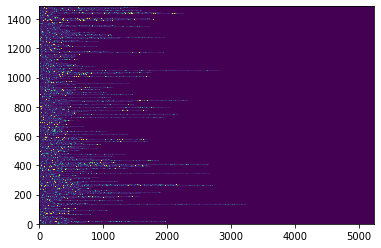

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

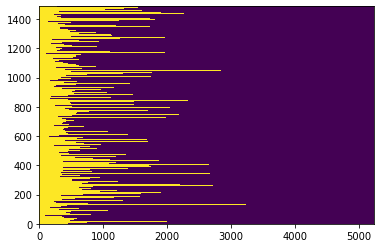

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

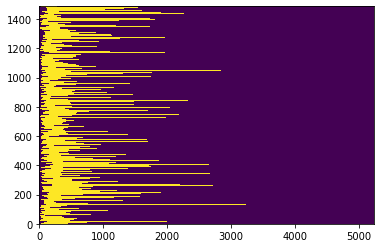

In [ ]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)


def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["Sentence_1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["Sentence_1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["Sentence_2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
df_train = bert_encode(df3, tokenizer)
#df_labels = df3['Relevancy_Score'].div(5)

df_test = bert_encode(df3_test, tokenizer)
df_test_labels = df3_test['Relevancy_Score'].div(5)

print(df_train)
print(df_test)

KeyError: ignored

In [ ]:
for key, value in df_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'df_labels shape: {df_labels.shape}')

input_word_ids  shape: (2396, 125)
input_mask      shape: (2396, 125)
input_type_ids  shape: (2396, 125)
df_labels shape: (2396,)


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
print(bert.bert_models)
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
   bert_config, num_labels=1)

<module 'official.nlp.bert.bert_models' from '/usr/local/lib/python3.6/dist-packages/official/nlp/bert/bert_models.py'>


In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
glue_batch = {key: val[:10] for key, val in df_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.17102675],
       [ 0.07586445],
       [ 0.01797828],
       [-0.19046766],
       [-0.06210539],
       [-0.09033417],
       [ 0.01831295],
       [-0.08006046],
       [-0.22937882],
       [-0.03147416]], dtype=float32)

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
[print(i.shape, i.dtype) for i in bert_classifier.inputs]
[print(o.shape, o.dtype) for o in bert_classifier.outputs]
[print(l.name, l.input_shape, l.dtype) for l in bert_classifier.layers]
bert_classifier.summary()

(None, None) <dtype: 'int32'>
(None, None) <dtype: 'int32'>
(None, None) <dtype: 'int32'>
(None, 1) <dtype: 'float32'>
input_word_ids [(None, None)] int32
input_mask [(None, None)] int32
input_type_ids [(None, None)] int32
transformer_encoder [(None, None), (None, None), (None, None)] float32
dropout_1 (None, 768) float32
classification (None, 768) float32
Model: "bert_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputL

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Set up epochs and steps
epochs = 2
batch_size = 32
eval_batch_size = 32

train_data_size = len(df_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metric = [tf.keras.metrics.Accuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.MeanAbsoluteError()

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['mse', 'mae', 'mape', 'cosine_similarity','accuracy'])

bert_classifier.fit(
      df_train, df_labels,
      batch_size=32,
      epochs=epochs)

Epoch 1/2
75/75 [==============================] - 3287s 44s/step - loss: 0.3301 - mse: 0.1647 - mae: 0.3301 - mape: 26140062.6908 - cosine_similarity: 0.8531 - accuracy: 0.0810
Epoch 2/2
75/75 [==============================] - 3245s 43s/step - loss: 0.1562 - mse: 0.0406 - mae: 0.1562 - mape: 11219197.4079 - cosine_similarity: 0.8746 - accuracy: 0.1360


In [ ]:
export_dir='./saved_model2'
tf.saved_model.save(bert_classifier, export_dir=export_dir)


INFO:tensorflow:Assets written to: ./saved_model2/assets


INFO:tensorflow:Assets written to: ./saved_model2/assets


In [ ]:
bert_classifier.evaluate(df_test,df_test_labels)

19/19 [==============================] - 172s 9s/step - loss: 0.1405 - mse: 0.0355 - mae: 0.1405 - mape: 12436080.0000 - cosine_similarity: 0.8980 - accuracy: 0.1405


[0.140456423163414,
 0.03549607843160629,
 0.140456423163414,
 12436080.0,
 0.8979933261871338,
 0.14046822488307953]

In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'Sentence_1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.',
            'I am alive.'],
        'Sentence_2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.',
            "I am alive."]
    },
    tokenizer=tokenizer)
result = bert_classifier(my_examples, training=False)

print(result)

#result = tf.argmax(result).numpy()

array = result.numpy()

def normalize(value):
	normalized = (value + 1) / (2);
	return normalized;


for i in array:
  x = normalize(i)
  print()

tf.Tensor(
[[0.6340052]
 [0.1166743]
 [0.7393124]], shape=(3, 1), dtype=float32)





In [ ]:
!pip install h5py

In [ ]:
bert_classifier.save("./model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[0.6340052]
 [0.1166743]
 [0.7393124]]

[[0.63400537]
 [0.11667421]
 [0.7393121 ]]


In [ ]:
uploaded2 = files.upload()


predict = pd.read_csv(io.BytesIO(uploaded2['valtest.csv']))

predicter = bert_encode(glue_dict={"Sentence_1":predict['Sentence_1'],'Sentence_2': predict["Sentence_2"]}, tokenizer = tokenizer)

solutions = bert_classifier.predict(predicter)

Saving valtest.csv to valtest.csv


In [ ]:
#a = (df.abs())

#b = normalized_predict

diff_pred = (solutions.tolist())

#print(diff_pred)

new_solutions = []
for i in diff_pred:
  for x in i:
    new_solutions.append(x)

ans = pd.Series(new_solutions)-predict['Relevancy_Score'].div(5)

print(ans.abs().describe().transpose())



count    750.000000
mean       0.126923
std        0.096725
min        0.000204
25%        0.052139
50%        0.108334
75%        0.178874
max        0.557846
dtype: float64


In [ ]:

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')



BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [ ]:
#Using the PREPROCESSING Model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!', 'I am Alive. I am Indebted','Praise to God almighty']
text_preprocessed = bert_preprocess_model(df2.Sentence_1)

print(text_preprocessed)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

#Using the BERT Model
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(bert_results)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

ValueError: ignored

In [ ]:
sentence1_input = tf.keras.Input(shape=(), dtype=tf.string, name = "Sentence1")
sentence2_input = tf.keras.Input(shape=(), dtype=tf.string, name = "Sentence2")
relevancyinput = tf.keras.Input(shape=(1), name = "RelevancyScore")

sentencepreprocessing = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing1')

sentence1_preprocessing = sentencepreprocessing(sentence1_input)
sentence2_preprocessing = sentencepreprocessing(sentence2_input)

sentencebert = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder1')

sentence1_bert = sentencebert(sentence1_preprocessing)
sentence2_bert = sentencebert(sentence2_preprocessing)


concatenate_all = tf.keras.layers.concatenate([relevancyinput, sentence1_bert["pooled_output"], sentence2_bert["pooled_output"]])
neta2 = tf.keras.layers.Dense(1024, activation=None, name='sts1')(concatenate_all)
neta3 = tf.keras.layers.Dense(768, activation=None, name='sts2')(neta2)
net = tf.keras.layers.Dense(1, activation=None, name='sts')(neta3)

model = tf.keras.Model(
    inputs=[sentence1_input, sentence2_input],
    outputs=[net],
)

In [ ]:
def CosineSimilarity(a,b):
  #a**b/squareroot(summation of a^2)**squaeroot(summation of b^2)
  for i in a:
    for o im b:
      a *

In [ ]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]
model.summary()

(None,) <dtype: 'string'>
(None,) <dtype: 'string'>
(None, 1) <dtype: 'float32'>
Sentence1 [(None,)] string
Sentence2 [(None,)] string
preprocessing1 None float32
BERT_encoder1 {'input_word_ids': (None, 128), 'input_mask': (None, 128), 'input_type_ids': (None, 128)} float32
concatenate_5 [(None, 512), (None, 512)] float32
sts1 (None, 1024) float32
sts2 (None, 1024) float32
sts (None, 768) float32
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sentence1 (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
Sentence2 (InputLayer)          [(None,)]            0                                            
________________________________________________________________________________________

In [ ]:
                                                                                                                                                                                                                      #Defining the loss function
loss = tf.keras.losses.MeanAbsoluteError()
metrics = tf.metrics.Accuracy()

#Defining the Optimizer
epochs = 4
steps_per_epoch = 5
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,num_train_steps=num_train_steps,num_warmup_steps=num_warmup_steps,optimizer_type='adamw')

#Loading the BERT Model and Training
model.compile(optimizer=optimizer,loss=loss,metrics=['mse', 'mae', 'mape', 'cosine_similarity','accuracy'])

print(df3["Relevancy_Score"])

sentence1_data = (df3.Sentence_1).astype("string")
relevancydata = pd.to_numeric((df3['Relevancy_Score']),errors='coerce')
normalized = relevancydata.div(5)
sentence2_data = (df3.Sentence_2).astype("string")
print(normalized)
print(type(sentence1_data[1]))

model.fit(
    {"Sentence1": sentence1_data, "Sentence2": sentence2_data}, y = normalized, epochs=epochs )

print(f'Training model with {tfhub_handle_encoder}')

776     4.0
1424    3.0
227     4.7
2402    0.8
104     5.0
       ... 
409     4.4
1623    2.8
115     5.0
288     4.6
2510    0.4
Name: Relevancy_Score, Length: 2305, dtype: float64
776     0.80
1424    0.60
227     0.94
2402    0.16
104     1.00
        ... 
409     0.88
1623    0.56
115     1.00
288     0.92
2510    0.08
Name: Relevancy_Score, Length: 2305, dtype: float64
<class 'str'>
Epoch 1/4
73/73 [==============================] - 312s 4s/step - loss: 0.4590 - mse: 0.3090 - mae: 0.4590 - mape: 98865381.2973 - cosine_similarity: 0.9011 - accuracy: 0.0438
Epoch 2/4
73/73 [==============================] - 306s 4s/step - loss: 0.4504 - mse: 0.2993 - mae: 0.4504 - mape: 89167020.2162 - cosine_similarity: 0.9108 - accuracy: 0.0476
Epoch 3/4
73/73 [==============================] - 308s 4s/step - loss: 0.4469 - mse: 0.2979 - mae: 0.4469 - mape: 92691536.1622 - cosine_similarity: 0.9073 - accuracy: 0.0570
Epoch 4/4
73/73 [==============================] - 305s 4s/step - loss: 0.4534 

In [ ]:



df3_test = df2_test.dropna()

print(df3_test.describe().transpose())

sentence1_test = df3_test["Sentence_1"]
sentence2_test = df3_test["Sentence_2"]
relevancy_test = df3_test["Relevancy_Score"]
normalized_test = relevancy_test.div(5)
metric = tf.metrics.CosineSimilarity()
losses = model.evaluate({"Sentence1": sentence1_test, "Sentence2": sentence2_test}, {"sts": normalized_test})

print(f'Loss: {losses}')


NameError: ignored

In [ ]:
uploaded2 = files.upload()

predict = pd.read_csv(io.BytesIO(uploaded2['predict.csv']))


sentence1_predict = predict["Sentence_1"]
sentence2_predict = predict["Sentence_2"]
relevancy_predict = predict["Relevancy_Score"]
normalized_predict = relevancy_predict.div(5)


solutions = model.predict({"Sentence1": sentence1_predict, "Sentence2": sentence2_predict})

Saving predict.csv to predict (1).csv


In [ ]:

newList = []
for x in solutions:
    newList.append(x*5)

df = pd.DataFrame(solutions)
fileName = 'prdict.csv'
df.to_csv(fileName)

print(df)

           0
0  -0.296717
1  -0.083558
2   0.316203
3  -0.035383
4   0.340398
5   0.672012
6   0.557940
7   0.458394
8   0.027319
9   0.368085
10  0.478323
11  0.515013
12  1.077829
13  0.733209
14  0.935209
15  0.316129
16  0.044420
17  0.027349
18  0.295618
19  0.381707
20  0.388599
21  0.310701
22  0.688457
23 -0.062880
24  0.946695
25 -0.148819
26  0.647570
27  0.811228
28  0.595808
29  0.022950


In [ ]:
a = (df.abs())

b = normalized_predict

diff_pred = (b).subtract(a)

print(diff_pred[0].abs())

diff_pred[0].abs().describe().transpose()

print((1 - diff_pred[0].abs()).sum())

NameError: ignored

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
model.save(saved_model_path, include_optimizer=False)